In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# # 5. Configure a new global `tensorflow` session
# from keras import backend as K
# # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# # K.set_session(sess)
# # for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# tf.compat.v1.set_random_seed(seed_value)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

from pandas import read_csv
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
# from numba import jit

In [2]:
def differentiate_column(column):
    return column.diff().fillna(0)  # Using .diff() for differencing and filling NaNs with 0

def supervisedReframer(df, steps_back=1, steps_forward=1):
    new_df = pd.DataFrame()
    new_df['Date'] = df['Date'].copy()
    new_df['Date'] = pd.to_datetime(new_df['Date'], origin='1899-12-30', unit='D')

    # for col in df.columns:
    #     if col != "Date":
    #         df[col] =  differentiate_column(df[col])
    
    for col in df.columns:
        if col != "Date":
            for shift in range(steps_back, -1, -1):
                if shift != 0:
                    new_col_name = f"{col} (t-{shift})"
                else:
                    new_col_name = f"{col}"
                new_df[new_col_name] = df[col].shift(+shift).copy()

    for steps in range(1, steps_forward+1):
        new_col_name = f"Target (t+{steps})"
        new_df[new_col_name] = df['Adj Close'].shift(-steps).copy()

    new_df.dropna(inplace=True)

    return new_df

# def supervisedReframer(df, steps_back=1, steps_forward=1):
#     new_df = pd.DataFrame()
#     new_df['Date'] = df['Date'].copy()
    
#     # Shift columns backward
#     shifted_cols = {}
#     for col in df.columns:
#         if col != "Date":
#             shifted_cols[col] = [df[col].shift(-shift).copy() for shift in range(steps_back, -1, -1)]
#             new_col_names = [f"{col} (t-{shift})" if shift != 0 else f"{col}" for shift in range(steps_back, -1, -1)]
#             new_df = pd.concat([new_df] + shifted_cols[col], axis=1)
#             new_df.columns = new_df.columns[:1].tolist() + new_col_names + new_df.columns[1+len(new_col_names):].tolist()

#     # Shift 'Adj Close' column forward
#     for steps in range(1, steps_forward+1):
#         new_col_name = f"Adj Close (t+{steps})"
#         new_df[new_col_name] = df['Adj Close'].shift(-steps).copy()
    
#     return new_df

def reshaper(data,  n_timestamps, n_features):
    n_samples = data.shape[0]

    result = np.empty((n_samples, n_timestamps, n_features))
    for i in range(n_samples):
        c=0
        for j in range (n_features):
            for k in range(n_timestamps):
                result[i][k][j]=data[i][c]
                c+=1
    
    return result

def TrainValTestSplit(dataframe, backwards_steps=1,forward_steps=1, n_features=1):
    forward_steps+=1
    df=dataframe.copy()
    df['Year'] = df['Date'].dt.year.copy()

    # Determine the years for training, validation, and testing
    training_years = df['Year'].unique()[-8:-2]  # All years except the last two
    validation_year = df['Year'].unique()[-2]  # Second to last year
    testing_year = df['Year'].unique()[-1]  # Last year

    # Select columns for X and y
    X_columns = df.columns[1:-forward_steps]
    y_columns = df.columns[-forward_steps:-1]
    
    # Filter the data based on the years
    X_train = df[df['Year'].isin(training_years)][X_columns].values
    y_train = df[df['Year'].isin(training_years)][y_columns].values
    
    X_val = df[df['Year'] == validation_year][X_columns].values
    y_val = df[df['Year'] == validation_year][y_columns].values
    
    X_test = df[df['Year'] == testing_year][X_columns].values
    y_test = df[df['Year'] == testing_year][y_columns].values
    
    scaler = MinMaxScaler()
    
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    X_test = scaler.fit_transform(X_test)
    
    y_train = scaler.fit_transform(y_train)
    y_val = scaler.fit_transform(y_val)
    y_test = scaler.fit_transform(y_test)

    X_train = reshaper(X_train, backwards_steps+1, n_features)
    X_val = reshaper(X_val, backwards_steps+1, n_features)
    X_test = reshaper(X_test, backwards_steps+1, n_features)

    y_train = y_train.reshape((y_train.shape[0], forward_steps-1, 1))
    y_val = y_val.reshape((y_val.shape[0], forward_steps-1, 1))
    y_test = y_test.reshape((y_test.shape[0], forward_steps-1, 1))
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
def runModel():
    results = []
    for i in tqdm(range(1,6)):
        n_steps_back = (i-1)*2 # Ako je 0, to znaci da koristis danas da predvidis sutra
        n_steps_forward = i #Ako je 0, jbg ne predvidjas ista
        
        # load dataset
        dataset = read_csv('CSV Files with Calculated Indicators/NYSE.csv', low_memory=False, header=0, index_col=None)
        
        df = pd.DataFrame({
            'Date': dataset['Date'], 
            'Adj Close': dataset['Adj Close']})
        
        n_features = df.shape[1]-1
        
        moved_df = supervisedReframer(df, n_steps_back, n_steps_forward).copy()
        
        X_train,y_train,X_val,y_val,X_test,y_test = TrainValTestSplit(moved_df,n_steps_back,n_steps_forward,n_features)
        
        ### Create the model
        inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
        x = keras.layers.LSTM(50, return_sequences=True)(inputs)
        x = keras.layers.LSTM(50) (x)
        outputs = keras.layers.Dense(n_steps_forward, activation='linear')(x)
        
        # optimizer = keras.optimizers.Adam(learning_rate=0.1)
        # model.compile(optimizer=optimizer, loss="mse")
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss="mse")
        # model.summary()
        
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            patience=5,           # Number of epochs to wait before stopping
            restore_best_weights=True  # Restore weights to the best observed during training
        )
    
        if n_steps_back==0:
            batch = 1
        else:
            batch = n_steps_back
        
        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs = 100,
            batch_size = batch,
            validation_data=(X_val, y_val),
            verbose=1,
            shuffle=False,
            callbacks=[early_stopping]
        )
        
        results.append(r2_score(np.squeeze(y_test, axis=-1), model.predict(X_test)))
        
    # Plot the values
    plt.plot(results)
    
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Plot of List Values')
    
    # Show the plot
    plt.show()


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 5, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 5, 30)               │           9,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 10)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,771 (85.04 KB)

 Trainable params: 21,771 (85.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0229 - val_loss: 0.0820
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0581 - val_loss: 0.0302
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0158 - val_loss: 0.0126
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 0.0085
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.4316e-04 - val_loss: 0.0083
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4624e-04 - val_loss: 0.0083
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5407e-04 - val_loss: 0.0083
Epoch 8/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.2497e-04 - val_loss: 0.0083
Epoch 9/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9947e-04 - val_loss: 0.0083
Epoch 10/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8762e-04 - val_loss: 0.0083
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
LSTM coefficient of determination of the prediction:  0.854607053742832


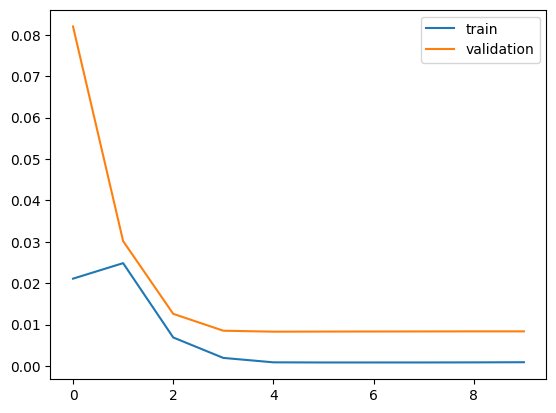

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


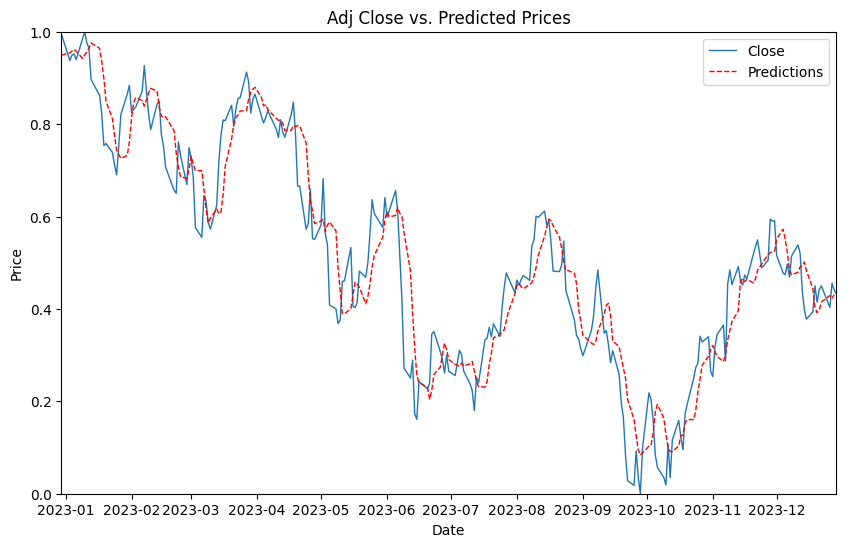

In [15]:
n_steps_back = 4 # Ako je 0, to znaci da koristis danas da predvidis sutra
n_steps_forward = 1 #Ako je 0, jbg ne predvidjas ista

# load dataset
dataset = read_csv('CSV Files with Calculated Indicators/NYSE.csv', low_memory=False, header=0, index_col=None)

# df = dataset

df = pd.DataFrame({
    'Date': dataset['Date'], 
    'Adj Close': dataset['Adj Close']})

n_features = df.shape[1]-1

moved_df = supervisedReframer(df, n_steps_back, n_steps_forward).copy()

X_train,y_train,X_val,y_val,X_test,y_test = TrainValTestSplit(moved_df,n_steps_back,n_steps_forward,n_features)

### Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(50, return_sequences=True)(inputs)
x = keras.layers.LSTM(30, return_sequences=True)(x)
x = keras.layers.LSTM(10)(x)
outputs = keras.layers.Dense(n_steps_forward, activation='linear')(x)

# optimizer = keras.optimizers.Adam(learning_rate=0.1)
# model.compile(optimizer=optimizer, loss="mse")

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
model.summary()

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore weights to the best observed during training
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 15,
    batch_size = 32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]
)

# estimate the R2 on the test set
print("LSTM coefficient of determination of the prediction: ", r2_score(np.squeeze(y_val, axis=-1), model.predict(X_val)))

# fit model
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

X_test_skimmed = X_val[::n_steps_forward]
y_test_skimmed = y_val[::n_steps_forward]

predictions = model.predict(X_test_skimmed)

y_test_skimmed = np.squeeze(y_test_skimmed, axis=-1).flatten()

predictions = predictions.ravel()

graph_df = pd.DataFrame({
    'True': y_test_skimmed, 
    'Predictions': predictions})

last_n_dates = df['Date'].tail(len(graph_df)).tolist()
graph_df['Date'] = last_n_dates

graph_df['Date'] = pd.to_datetime(graph_df['Date'], origin='1899-12-30', unit='D')

graph_df['Predictions'] = graph_df['Predictions'].shift(-1)

#Plotting
x_min = graph_df['Date'].iloc[0]  # Replace with your desired minimum x-axis value
x_max = graph_df['Date'].iloc[-1]  # Replace with your desired maximum x-axis value
y_min = min(graph_df['True'].min(), graph_df['Predictions'].min())  # Replace with your desired minimum y-axis value
y_max = max(graph_df['True'].max(), graph_df['Predictions'].max())  # Replace with your desired maximum y-axis value

# Assuming your DataFrame is named df
# Replace 'Date', 'Close', and 'Predicted' with your actual column names
plt.figure(figsize=(10, 6))
plt.plot(graph_df['Date'], graph_df['True'], label='Close', linewidth=1)
plt.plot(graph_df['Date'], graph_df['Predictions'], label='Predictions', linestyle='dashed', color='red', linewidth=1)

# Customize the plot
plt.title('Adj Close vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Set x-axis and y-axis value ranges
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.grid(False)
plt.xticks(rotation=0)

# Show the plot
plt.show()

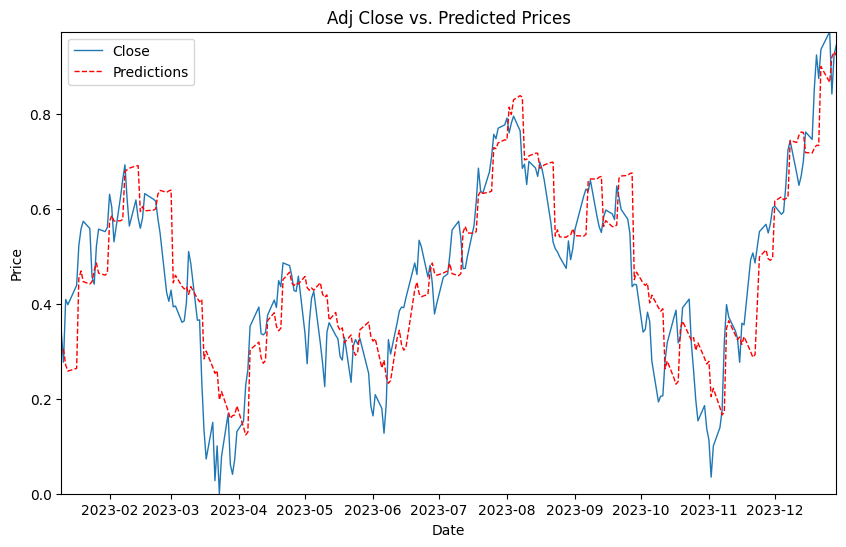

In [8]:
graph_df['Predictions'] = graph_df['Predictions'].shift(+1)

#Plotting
x_min = graph_df['Date'].iloc[0]  # Replace with your desired minimum x-axis value
x_max = graph_df['Date'].iloc[-1]  # Replace with your desired maximum x-axis value
y_min = min(graph_df['True'].min(), graph_df['Predictions'].min())  # Replace with your desired minimum y-axis value
y_max = max(graph_df['True'].max(), graph_df['Predictions'].max())  # Replace with your desired maximum y-axis value

# Assuming your DataFrame is named df
# Replace 'Date', 'Close', and 'Predicted' with your actual column names
plt.figure(figsize=(10, 6))
plt.plot(graph_df['Date'], graph_df['True'], label='Close', linewidth=1)
plt.plot(graph_df['Date'], graph_df['Predictions'], label='Predictions', linestyle='dashed', color='red', linewidth=1)

# Customize the plot
plt.title('Adj Close vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Set x-axis and y-axis value ranges
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.grid(False)
plt.xticks(rotation=0)

# Show the plot
plt.show()